In [8]:
%load_ext autoreload
%autoreload 2
import netCDF4
import xarray as xr
from pathlib import Path
from hmpai.pytorch.models import *
from hmpai.training import split_data_on_participants, split_participants
from hmpai.pytorch.training import train, validate, calculate_class_weights, train_and_test, k_fold_cross_validate, test, calculate_global_class_weights
from hmpai.pytorch.utilities import DEVICE, set_global_seed, get_summary_str, save_model, load_model
from hmpai.pytorch.generators import SAT1Dataset, MultiXArrayDataset, MultiXArrayProbaDataset
from hmpai.data import SAT1_STAGES_ACCURACY, SAT_CLASSES_ACCURACY
# from hmpai.visualization import plot_confusion_matrix
from hmpai.pytorch.normalization import *
from torchinfo import summary
from hmpai.utilities import print_results, CHANNELS_2D, AR_SAT1_CHANNELS, get_masking_index
from torch.utils.data import DataLoader
# from braindecode.models.eegconformer import EEGConformer
from mne.io import read_info
import os
DATA_PATH = Path(os.getenv("DATA_PATH"))
from hmpai.visualization import *
from hmpai.behaviour.sat2 import read_behavioural_info, SAT2_SPLITS, merge_data
from hmpai.pytorch.mamba import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Set base variables
set_global_seed(42)
data_paths = [DATA_PATH / "sat2/stage_data_proba_250hz_step5_50.nc"]
# train_percentage=100 makes test and val 100 as well
# splits = split_participants(data_paths, train_percentage=60)
splits = SAT2_SPLITS
labels = SAT_CLASSES_ACCURACY
whole_epoch = True
info_to_keep = ['event_name', 'participant', 'epochs', 'rt']
subset_cond = None # 'speed'|'accuracy'|None
skip_samples = 62 #62
cut_samples = 63 #63
add_negative = False

In [3]:
# Create datasets
norm_fn = norm_mad_zscore
statistics = {
    "global_min": -0.00014557216,
    "global_max": 0.00014740844,
    "global_mean": -2.277374212336032e-18,
    "global_std": 3.3968840765876904e-06,
    "global_median": 3.4879516e-11,
    "mad_score": 3.2237037e-06,
    "class_weights": Tensor([0.0, 0.0, 0.0, 0.0, 0.0]),
}
norm_vars = get_norm_vars_from_global_statistics(statistics, norm_fn)

train_data = MultiXArrayProbaDataset(
    data_paths,
    participants_to_keep=splits[0],
    normalization_fn=norm_fn,
    whole_epoch=whole_epoch,
    labels=labels,
    info_to_keep=info_to_keep,
    subset_cond=subset_cond,
    statistics=statistics,
    skip_samples=skip_samples,
    cut_samples=cut_samples,
    add_negative=add_negative,
)
class_weights = train_data.statistics["class_weights"]
test_data = MultiXArrayProbaDataset(
    data_paths,
    participants_to_keep=splits[1] + splits[2],
    normalization_fn=norm_fn,
    norm_vars=norm_vars,
    whole_epoch=whole_epoch,
    labels=labels,
    info_to_keep=info_to_keep,
    subset_cond=subset_cond,
    skip_samples=skip_samples,
    cut_samples=cut_samples,
    add_negative=add_negative,
)

In [4]:
chk_path = Path("../../models/attlab_jitter.pt")
checkpoint = load_model(chk_path)

model = base_mamba()
# model = TestMamba(64, 128, 19, 5, 5, False)
# model = TestMamba(64, 128, 64, len(labels), 5, False)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(DEVICE)
model.eval();

In [5]:
# Load in behavioural data
behaviour_sat2 = read_behavioural_info(DATA_PATH / "sat2/behavioural/df_full.csv")
test_loader_sat2 = DataLoader(
    test_data, batch_size=128, shuffle=True, num_workers=8, pin_memory=True
)

In [ ]:
s3_trials = behaviour_sat2[behaviour_sat2['participant'] == 'S3'].trial.tolist()
for i, epoch in enumerate(s3_trials):
    if i > 0:
        if s3_trials[i-1] + 1 != epoch:
            print(s3_trials[i], s3_trials[i - 1])

{'event_name': 'low/speed/left/2', 'participant': 'S3', 'epochs': 2164, 'rt': 0.3173828125}
        FC    SAT expdResp  contrast   N200  trial participant givenResp  \
25848  1.0  speed    right         1  180.0   2164          S3     right   

       response     rt        prmt         mt trialType EMG_sequence  
25848         1  250.0  172.851558  77.148442        SA           CR  
RT/masking index ratio: 2.7472527027130127


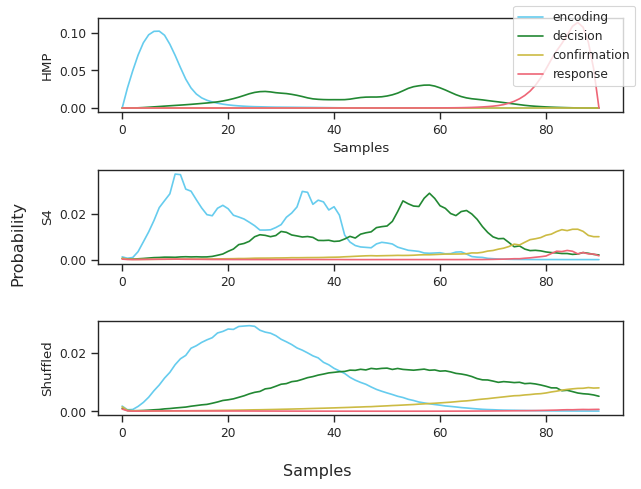

In [75]:
display_trial(model, test_data, behaviour_sat2, 5175, labels)

In [ ]:
for i in torch.randint(len(test_data), (10,)):
    print(i)
    display_trial(model, test_data, behaviour_sat2, i, labels)

In [6]:
data = predict_with_auc(model, test_loader_sat2, info_to_keep, labels)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1716905971132/work/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv1d(input, weight, bias, self.stride,


In [7]:
data

,event_name,participant,epochs,rt,rt_index_samples,negative_auc,encoding_auc,decision_auc,confirmation_auc,response_auc
0,low/accuracy/left/1,S15,1604,0.489258,134,461.483948,0.676338,0.758262,0.279115,0.802326
1,low/speed/left/3,S10,1999,0.389648,109,461.477356,0.707158,0.739487,0.361478,0.714548
2,low/accuracy/right/1,S15,2297,0.435547,121,461.196594,0.850783,0.841540,0.263924,0.847167
3,low/speed/left/1,S5,166,0.570312,155,460.844971,0.775117,0.796865,0.653996,0.929051
4,low/accuracy/left/2,S7,2282,0.514648,141,460.789978,1.195170,0.887217,0.503312,0.624336
...,...,...,...,...,...,...,...,...,...,...
36,low/speed/left/3,S17,1348,0.292969,85,288.342499,0.729418,0.827153,0.092598,1.008347
37,low/speed/right/1,S15,1725,0.437500,121,287.771667,0.905131,1.096856,0.266626,0.959714
38,low/accuracy/left/2,S15,1545,0.359375,102,288.204926,0.924915,0.819796,0.230528,0.819862
39,low/accuracy/right/2,S4,542,0.911133,240,287.536072,0.759687,0.915879,1.013265,0.775080


In [ ]:
# 1m26
data = merge_data(data, behaviour_sat2)

In [33]:
test_data

,event_name,participant_x,epochs,rt_x,rt_index_samples,negative_auc,encoding_auc,decision_auc,confirmation_auc,response_auc,...,N200,trial,participant_y,givenResp,response,rt_y,prmt,mt,trialType,EMG_sequence
0,low/accuracy/left/1,S15,1604,0.489258,134,461.483948,0.676338,0.758262,0.279115,0.802326,...,179.0,1604,S15,right,0,489.257812,413.085938,76.171875,MA,IIR
1,low/speed/left/3,S10,1999,0.389648,109,461.477356,0.707158,0.739487,0.361478,0.714548,...,177.0,1999,S10,left,1,389.648438,356.445315,33.203122,SA,CR
2,low/accuracy/right/1,S15,2297,0.435547,121,461.196594,0.850783,0.841540,0.263924,0.847167,...,180.0,2297,S15,right,1,435.546875,356.445312,79.101562,SA,CR
3,low/speed/left/1,S5,166,0.570312,155,460.844971,0.775117,0.796865,0.653996,0.929051,...,201.0,166,S5,left,1,570.312500,497.070312,73.242188,SA,CR
4,low/accuracy/left/2,S7,2282,0.514648,141,460.789978,1.195170,0.887217,0.503312,0.624336,...,151.0,671,S7,left,1,514.648438,290.039058,224.609380,MA,CCR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9636,low/speed/left/3,S17,1348,0.292969,85,288.342499,0.729418,0.827153,0.092598,1.008347,...,226.0,495,S17,left,1,292.968750,147.460933,145.507817,SA,CR
9637,low/speed/right/1,S15,1725,0.437500,121,287.771667,0.905131,1.096856,0.266626,0.959714,...,212.0,1725,S15,right,1,437.500000,327.148440,110.351560,SA,CR
9638,low/accuracy/left/2,S15,1545,0.359375,102,288.204926,0.924915,0.819796,0.230528,0.819862,...,NaN,1545,S15,left,1,359.375000,289.062505,70.312495,SA,CR
9639,low/accuracy/right/2,S4,542,0.911133,240,287.536072,0.759687,0.915879,1.013265,0.775080,...,NaN,542,S4,right,1,911.132812,811.523438,99.609375,SA,CR


In [79]:
# Check if this matches differently? Shouldnt
# p_trial_info = behaviour[(behaviour.trial == info['epochs']) & (behaviour.participant == info['participant'])]
data = data.merge(
    behaviour_sat2, left_on=["participant", "epochs"], right_on=["participant", "trial"]
)

In [80]:
(data['rt_y'] / data['rt_index_samples']).describe()

count    9603.000000
mean        3.638875
std         0.377575
min         1.374135
25%         3.540039
50%         3.631366
75%         3.715701
max        14.205823
dtype: float64

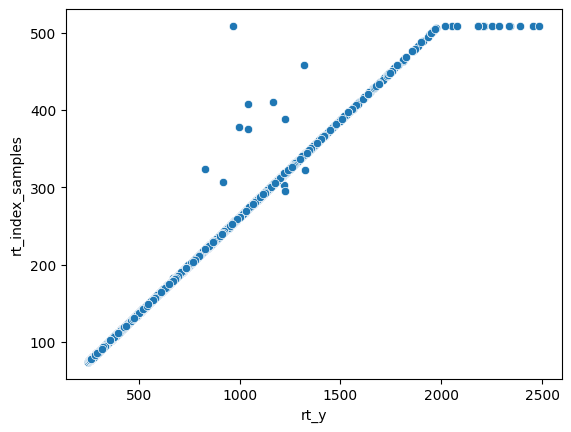

In [34]:
sns.scatterplot(test_data, x='rt_y', y='rt_index_samples')
plt.show()

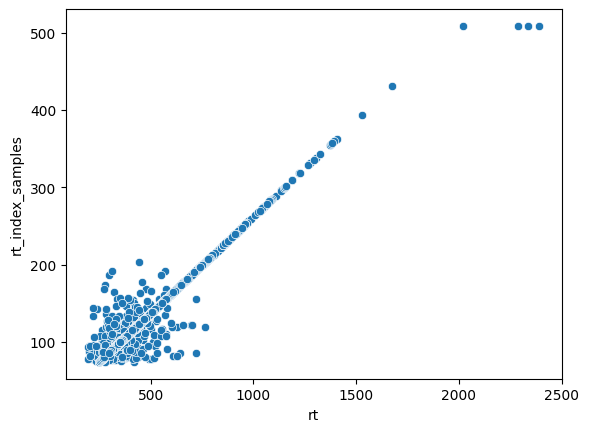

In [ ]:
import seaborn as sns
sns.scatterplot(data, x='rt', y='rt_index_samples')
plt.show()

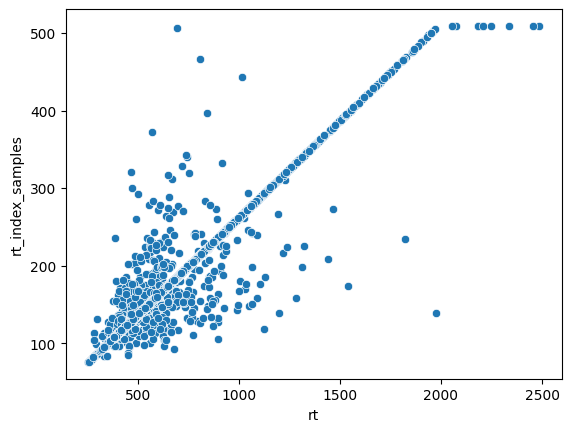

In [18]:
sns.scatterplot(data[data['SAT'] == 'accuracy'], x='rt', y='rt_index_samples')
plt.show()